# Single-step ("bandit") Principal-Agent payment schedule optimization

This notebook serves as a reference for running the training pipeline for the payment schedule optimization problem in the "bandit" setting -- where the principal determines a payment schedule and receives a sample reward based on the expected effort choices of the agent in response to the schedule.

In the first non-import cell, some important quantities are set, in particular **mi_lambda**. The rest of the parameters refer to the config file loaded in the cell that follows. You could run this notebook multiple times to produce a "sweep" over values such as ```mi_lambda```, ```entropy_lambda```, or ```qtemp_agent```.

In [1]:
%load_ext autoreload
%autoreload 2

import json
from argparse import Namespace
import os
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../agents')

import numpy as np
import torch
import yaml

from utils import *
from agents.pg_bandit_mvg_model import PGBanditMVGModel

## Set Run Parameters
All other parameters are in config_file

In [2]:
# The strength of non-utility rewards.
# MI refers to the penalty on mutual information between outcome and payment
# Entropy refers to the bonus on the entropy of the stochastic payment schedule
mi_lambda = 1.0
entropy_lambda = 0.0

if entropy_lambda > 0 and mi_lambda > 0:
    raise ValueError('Error: Both Entropy regularization and mutual information regularization are on!!')

# The Q temperature controlling the stochasticity of the agent. Higher values increase the probability of the
# agent selecting the optimal action.
qtemp_agent = 5.0

# Random seed for ensuring reproducibility.
random_seed = 0

# Where to look for other (static) hyperparameters
config_file = 'configs/bandit_config.yaml'

### Load in run parameters

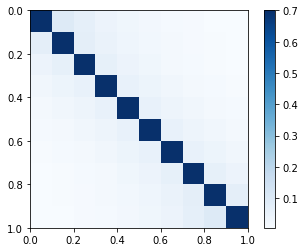

In [3]:
with open(config_file) as f:
    config_params = yaml.safe_load(f)
ns = Namespace(**config_params)
n_a_actions = int(ns.n_a_actions)
n_a_outputs = int(ns.n_a_outputs)

random_factor = ns.random_multiplier
a_o_mat = get_a_o_mat_exact_nc(n_a_actions, n_a_outputs, random_factor = random_factor)


params_dict = {
    'n_a_actions': n_a_actions,
    'n_a_outputs': n_a_outputs,
    'agent_exp': ns.agent_exp,
    'agent_work_multiplier': ns.agent_work_multiplier,
    'agent_pay_multiplier': ns.agent_pay_multiplier,
    'principal_profit_multiplier': ns.principal_profit_multiplier,
    'qtemp_agent': qtemp_agent,
    'use_truncated': ns.use_truncated,
    'random_type': ns.random_type,
    'random_factor': random_factor,
    'entropy_lambda': entropy_lambda
}

#Visualize the effort to output matrix
plt.colorbar(plt.imshow(a_o_mat, cmap='Blues', interpolation='nearest', extent=[0,1,1,0]))
plt.show()

### Train

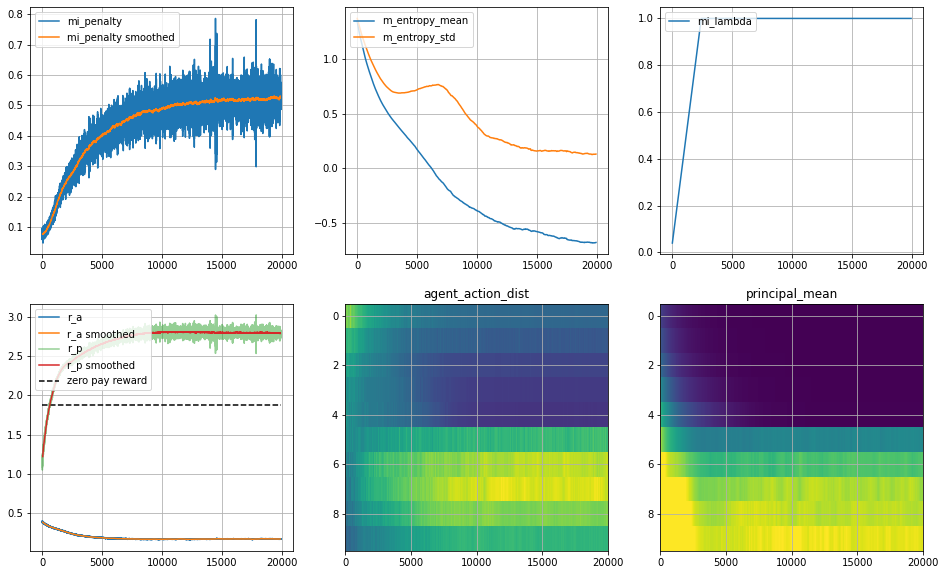

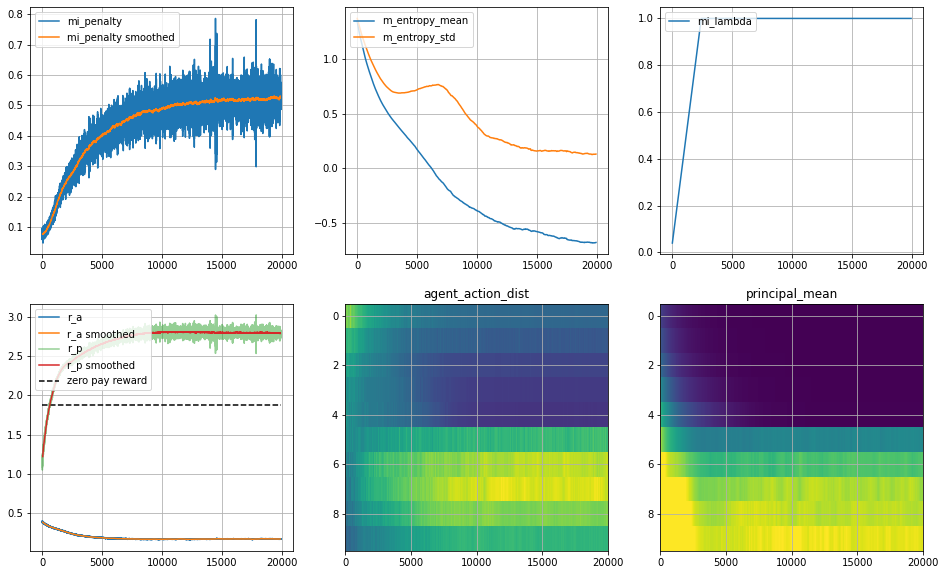

In [4]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

# Initialize the training history, the principal model, the optimizer, and the trainable MI classifier
hist = {}
pi_p = PGBanditMVGModel(n_a_outputs=n_a_outputs, initialize=True, d=0.0)
optim_p = torch.optim.Adam(pi_p.parameters(), lr=ns.lr_p)
mi_classifier = pretrain_mi_classifier(pi_p, a_o_mat, ns.n_batch, params_dict, n_iters=20, n_samples=1024)

############################################
# Trains (principal and classifier), and stores relevant values to history dictionary for plotting
train_principal(
    pi_p,
    optim_p,
    mi_classifier,
    mi_lambda,
    ns.n_batch,
    a_o_mat,
    params_dict,
    history=hist,
    n_timesteps=ns.n_timesteps,
    anneal_mi=ns.anneal_mi,
    anneal_speed=ns.anneal_speed,
    entropy_regularization=ns.entropy_regularization,
    entropy_anneal=ns.entropy_anneal,
    entropy_begin=ns.entropy_begin,
    should_plot=True
)

# Notes on plots:
# The heatmap for 'agent_action_dist' shows the probability (indicated by color) 
#    of the agent choosing each effort level (y-axis) over the course of training (x-axis)
# The heatmap for 'principal_mean' shows the average payment (indicated by color)
#    for each of the output levels (y-axis) over the course of training (x-axis)

### Save

After running the above cells, you can save the training objects (principal model/optimizer, history dictionary, mi classifier) for downstream analysis and/or further training.

**Note.** If you have already saved objects in ```ns.save_folder_experiment``` (see the config file) with the same hyperparameters and random seed, *this will overwrite*.

In [ ]:
if not os.path.isdir(ns.save_folder_experiments):
    os.makedirs(ns.save_folder_experiments)

save_principal(pi_p, ns.save_folder_experiments, mi_lambda, random_seed, params_dict)
save_partial_history(hist, ns.save_folder_experiments, mi_lambda, random_seed, params_dict, num_save=-1)
save_mi_classifier(mi_classifier, ns.save_folder_experiments, mi_lambda, random_seed, params_dict)
save_principal_optimizer(optim_p, ns.save_folder_experiments, mi_lambda, random_seed, params_dict)